NEW MODEL

In [2]:
import pymc as pm
import numpy as np
import jax
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from scipy.stats import norm, gaussian_kde

def kl_divergence(p, q, bandwidth='scott'):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux,
    en utilisant l'estimation de densité par noyau.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :param bandwidth: Méthode pour estimer la largeur de bande ('scott', 'silverman' ou un nombre)
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Estimation de densité par noyau
    kde_p = gaussian_kde(p, bw_method=bandwidth)
    kde_q = gaussian_kde(q, bw_method=bandwidth)
    
    # Créez un espace d'échantillonnage
    x = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 10000)
    
    # Estimez les densités
    p_density = kde_p(x)
    q_density = kde_q(x)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_density += epsilon
    q_density += epsilon
    
    # Normalisez les densités
    p_density /= np.sum(p_density)
    q_density /= np.sum(q_density)
    
    # Calculez la divergence KL
    return np.sum(p_density * np.log(p_density / q_density))



In [4]:
import json

def load_data_from_json(file_path):
    """
    Load data from a JSON file and return it as a dictionary.
    
    :param file_path: Path to the JSON file
    :return: Dictionary containing the loaded data
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        print(f"Data successfully loaded from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None



In [5]:
data = load_data_from_json('data/sampled_data.json')

Data successfully loaded from data/sampled_data.json


In [5]:

graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
n_schools = 50
n_students = 50

unit_vars = ['a', 'c', 'e']
subunit_vars = ['b', 'd']
sizes = [n_students] * n_schools

In [6]:

# Hypothèses : Tu as des données disponibles sous forme de matrices
# A, C, E : (100,)
# B, D : (100, 50)
"""
A = np.random.normal(0, 1, 100)
C = np.random.normal(0, 1, 100)
E = np.random.normal(0, 1, 100)

B_observed = np.random.normal(0, 1, (100, 50))
D_observed = np.random.normal(0, 1, (100, 50))
"""

a = np.array([data[f'a{i}'] for i in range(n_schools)])
c = np.array([data[f'c{i}'] for i in range(n_schools)])
e = np.array([data[f'e{i}'] for i in range(n_schools)])

# For b and d, we need to create 2D arrays
b = np.array([[data[f'_b{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])
d = np.array([[data[f'_d{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])




In [7]:
print(a)

[-2.28518092 -0.18706956 -0.89579762  1.15814669  0.10234227  1.37361927
  1.12738924 -0.44909954 -0.67037546 -0.59114775  0.97079196 -0.06478065
  0.06568451  2.0657252  -0.01775167  2.09011736  0.62874429 -1.19238992
  0.13041571 -0.29539845  0.70097246 -2.24518876  0.1766883  -0.01262842
 -0.76635642  2.07172617  0.34349196  0.37867878  0.78489238 -1.53000665
  1.61932454 -0.57656184 -1.69092627 -0.08418004 -0.53016312  0.66155681
  0.13069028 -1.69781685  1.77786882 -0.71339937  0.77800513 -0.28269455
  0.91159501 -0.58727034 -0.32466117 -0.54765735 -1.31151056  0.54847825
  0.3616922  -0.55909829]


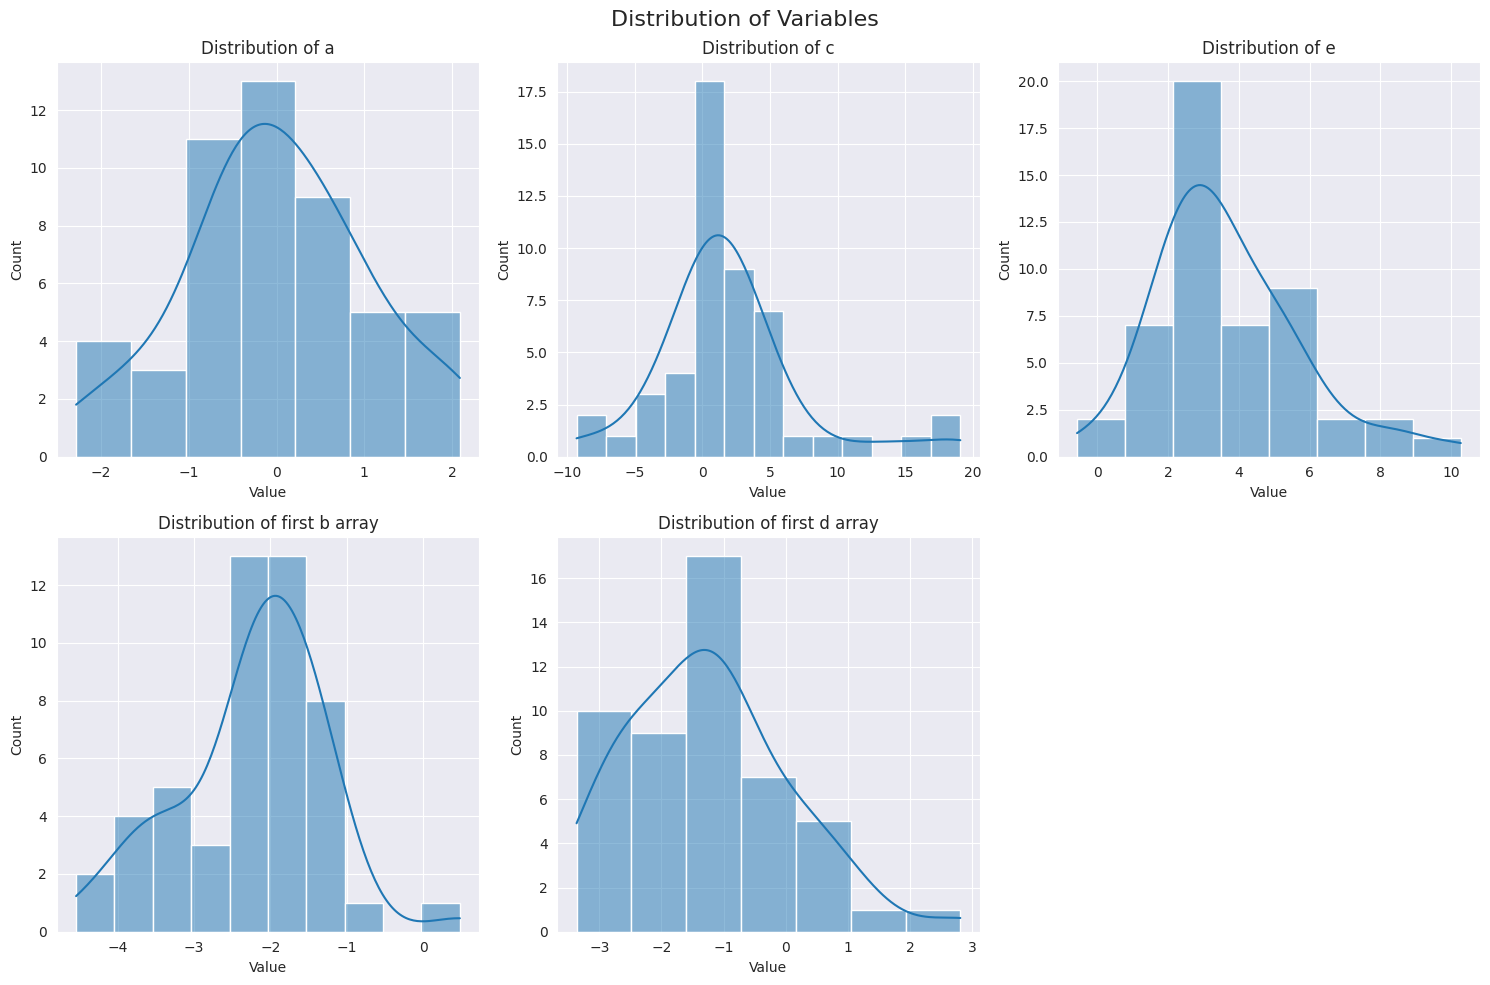

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Variables', fontsize=16)

# Plot distribution of a
sns.histplot(a, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of a')
axes[0, 0].set_xlabel('Value')

# Plot distribution of c
sns.histplot(c, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of c')
axes[0, 1].set_xlabel('Value')

# Plot distribution of e
sns.histplot(e, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of e')
axes[0, 2].set_xlabel('Value')

# Plot distribution of first b array
sns.histplot(b[0], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of first b array')
axes[1, 0].set_xlabel('Value')

# Plot distribution of first d array
sns.histplot(d[0], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of first d array')
axes[1, 1].set_xlabel('Value')

# Remove the unused subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


New model

In [9]:
print("Shape of a:", a.shape)
print("Shape of b:", b.shape)
print("Shape of c:", c.shape)
print("Shape of d:", d.shape)
print("Shape of e:", e.shape)


Shape of a: (50,)
Shape of b: (50, 50)
Shape of c: (50,)
Shape of d: (50, 50)
Shape of e: (50,)


---------------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------- Avec intervention -------------------------------------------------------------------------------------------

------------------------------------------------------------

In [10]:
with pm.Model() as model:
    # Niveau des écoles
    mu_A = pm.Normal('mu_A', mu=0, sigma=1)
    sigma_A = pm.HalfNormal('sigma_A', sigma=1)
    A_j = pm.Normal('A_j', mu=mu_A, sigma=sigma_A, observed=a)

    mu_C = pm.Normal('mu_C', mu=0, sigma=1)
    sigma_C = pm.HalfNormal('sigma_C', sigma=1)
    C_j = pm.Normal('C_j', mu=mu_C, sigma=sigma_C, observed=c)

    mu_E = pm.Normal('mu_E', mu=0, sigma=1)
    sigma_E = pm.HalfNormal('sigma_E', sigma=1)
    E_j = pm.Normal('E_j', mu=mu_E, sigma=sigma_E, observed=e)

    # B est maintenant une variable observée suivant une loi normale standard
    B_ij = pm.Normal('B_ij', mu=0, sigma=1, observed=b)

    # Modèle pour le poids des élèves (D) en fonction des autres variables
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_A = pm.Normal('beta_A', mu=0, sigma=1)
    beta_C = pm.Normal('beta_C', mu=0, sigma=1)
    beta_E = pm.Normal('beta_E', mu=0, sigma=1)
    beta_B = pm.Normal('beta_B', mu=0, sigma=1)
    sigma_D = pm.HalfNormal('sigma_D', sigma=1)

    mu_D = alpha + beta_A * A_j[:, None] + beta_C * C_j[:, None] + beta_E * E_j[:, None] + beta_B * B_ij
    D_ij = pm.Normal('D_ij', mu=mu_D, sigma=sigma_D, observed=d)

    # Inférence
    trace = pm.sample(50, return_inferencedata=True)

# Résumé des résultats
print(pm.summary(trace, var_names=['mu_A', 'mu_C', 'mu_E', 'alpha', 'beta_A', 'beta_C', 'beta_E', 'beta_B']))

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 25 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A    0.027  0.156  -0.266    0.261      0.008    0.010     443.0     192.0   
mu_C    1.407  0.542   0.289    2.358      0.025    0.018     460.0     231.0   
mu_E    3.368  0.257   2.918    3.811      0.017    0.012     235.0     113.0   
alpha   1.062  0.046   0.973    1.146      0.003    0.002     195.0     158.0   
beta_A  0.006  0.046  -0.081    0.091      0.003    0.003     211.0     137.0   
beta_C -0.010  0.009  -0.025    0.011      0.001    0.001     168.0     176.0   
beta_E -0.012  0.013  -0.038    0.009      0.001    0.001     181.0      71.0   
beta_B  1.052  0.020   1.018    1.088      0.001    0.001     432.0      83.0   

        r_hat  
mu_A     1.01  
mu_C     1.03  
mu_E     1.01  
alpha    1.02  
beta_A   1.02  
beta_C   1.03  
beta_E   1.00  
beta_B   1.02  


In [11]:
generated_data_cond = {}

# a
mu_A_posterior = trace.posterior['mu_A'].mean(dim=('chain', 'draw')).values
sigma_A_posterior = trace.posterior['sigma_A'].mean(dim=('chain', 'draw')).values
new_a = np.random.normal(mu_A_posterior, sigma_A_posterior, size=n_schools)
generated_data_cond['a'] = new_a

# c
mu_C_posterior = trace.posterior['mu_C'].mean(dim=('chain', 'draw')).values
sigma_C_posterior = trace.posterior['sigma_C'].mean(dim=('chain', 'draw')).values
new_c = np.random.normal(mu_C_posterior, sigma_C_posterior, size=n_schools)
generated_data_cond['c'] = new_c

# e
mu_E_posterior = trace.posterior['mu_E'].mean(dim=('chain', 'draw')).values
sigma_E_posterior = trace.posterior['sigma_E'].mean(dim=('chain', 'draw')).values
new_e = np.random.normal(mu_E_posterior, sigma_E_posterior, size=n_schools)
generated_data_cond['e'] = new_e


# Pour B
generated_data_cond['b'] = np.random.normal(0, 1, size=(n_schools, n_students))

# Pour D, nous devons recalculer mu_D en utilisant les paramètres estimés
alpha = trace.posterior['alpha'].mean(dim=('chain', 'draw')).values
beta_A = trace.posterior['beta_A'].mean(dim=('chain', 'draw')).values
beta_C = trace.posterior['beta_C'].mean(dim=('chain', 'draw')).values
beta_E = trace.posterior['beta_E'].mean(dim=('chain', 'draw')).values
beta_B = trace.posterior['beta_B'].mean(dim=('chain', 'draw')).values
sigma_D = trace.posterior['sigma_D'].mean(dim=('chain', 'draw')).values

# Calcul de mu_D
mu_D = (alpha + 
        beta_A * new_a[:, np.newaxis] + 
        beta_C * new_c[:, np.newaxis] + 
        beta_E * new_e[:, np.newaxis] + 
        beta_B * generated_data_cond['b'])

generated_data_cond['d'] = np.random.normal(mu_D, sigma_D)

# Affichage des formes des données générées
for var in ['a', 'b', 'c', 'd', 'e']:
    print(f"Shape of generated {var}: {generated_data_cond[var].shape}")

print("Generated data:", generated_data_cond)

Shape of generated a: (50,)
Shape of generated b: (50, 50)
Shape of generated c: (50,)
Shape of generated d: (50, 50)
Shape of generated e: (50,)
Generated data: {'a': array([-0.51777263,  0.08523656, -0.8644016 ,  1.61148613,  0.97039338,
       -1.26625219, -0.82369801, -0.57830111,  1.7874349 ,  1.49249019,
        0.56199501, -1.43311369,  0.17723747, -0.21509299,  0.28248677,
       -0.0561065 ,  0.18044218, -0.24435994,  1.6809085 ,  1.42041377,
        0.64909483, -1.15393634,  0.66863573,  1.45717084, -0.37578233,
       -0.49365512, -1.44252156, -0.14050226,  1.92802863,  2.09108204,
       -0.27520917,  0.63888868, -0.89398094,  0.87098499,  0.48281827,
        1.16415374,  1.85699429, -1.65908746, -2.54241182,  1.03502789,
        0.46722786,  0.60545274,  0.79501997,  0.71116616,  0.58986287,
        0.14678885,  0.61623746,  0.27928146, -0.17569675, -1.83106996]), 'c': array([-2.90252098e+00, -3.01574135e+00, -3.05242384e+00, -7.28734574e+00,
        3.23237357e+00, -1.283

In [12]:
# Calcul des divergences KL
kl_divs = {}

for var in ['a', 'b', 'c', 'd', 'e']:
    original = eval(var)  # Les données originales
    generated = generated_data_cond[var]  # Les données générées
    
    # Pour b et d, nous devons aplatir les arrays 2D
    if var in ['b', 'd']:
        original = original.flatten()
        generated = generated.flatten()
    
    kl_divs[var] = kl_divergence(original, generated)

# Affichage des résultats
for var, kl_div in kl_divs.items():
    print(f"KL divergence pour {var}: {kl_div}")

KL divergence pour a: 0.02572801312018938
KL divergence pour b: 0.14084845640500518
KL divergence pour c: 0.14755375959603623
KL divergence pour d: 0.03777068399074372
KL divergence pour e: 0.11012460989764056


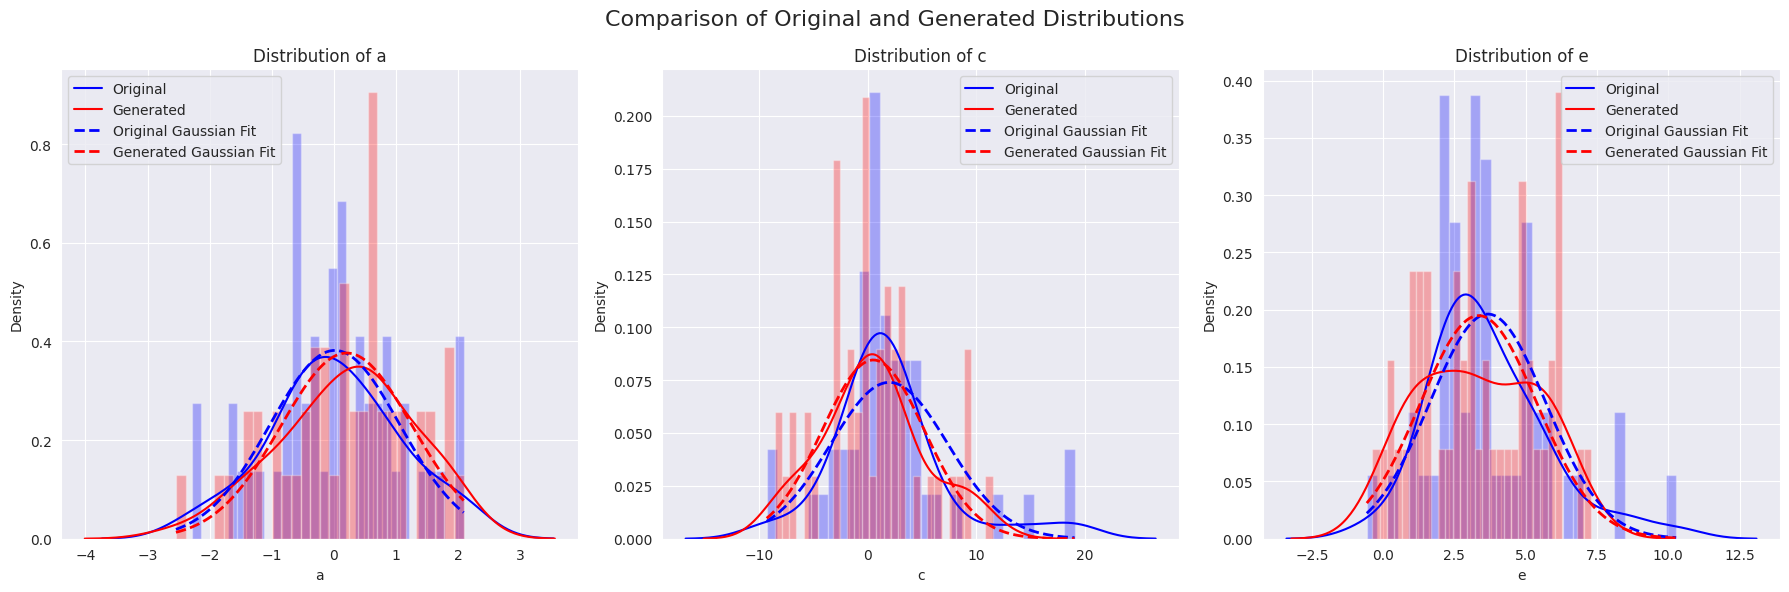

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Variables to plot
variables = ['a', 'c', 'e']

# Set up the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Comparison of Original and Generated Distributions', fontsize=16)

for i, var in enumerate(variables):
    ax = axes[i]
    
    # Original data
    original = eval(var)
    
    # Generated data
    generated = generated_data_cond[var]
    
    # KDE plot
    sns.kdeplot(original, ax=ax, label='Original', color='blue')
    sns.kdeplot(generated, ax=ax, label='Generated', color='red')
    
    # Histogram
    ax.hist(original, bins=30, alpha=0.3, color='blue', density=True)
    ax.hist(generated, bins=30, alpha=0.3, color='red', density=True)
    
    # Fit normal distribution
    mu_orig, std_orig = stats.norm.fit(original)
    mu_gen, std_gen = stats.norm.fit(generated)
    
    x = np.linspace(min(original.min(), generated.min()), 
                    max(original.max(), generated.max()), 100)
    
    ax.plot(x, stats.norm.pdf(x, mu_orig, std_orig), 
            'b--', linewidth=2, label='Original Gaussian Fit')
    ax.plot(x, stats.norm.pdf(x, mu_gen, std_gen), 
            'r--', linewidth=2, label='Generated Gaussian Fit')
    
    ax.set_title(f'Distribution of {var}')
    ax.set_xlabel(var)
    ax.set_ylabel('Density')
    ax.legend()

plt.tight_layout()
plt.show()


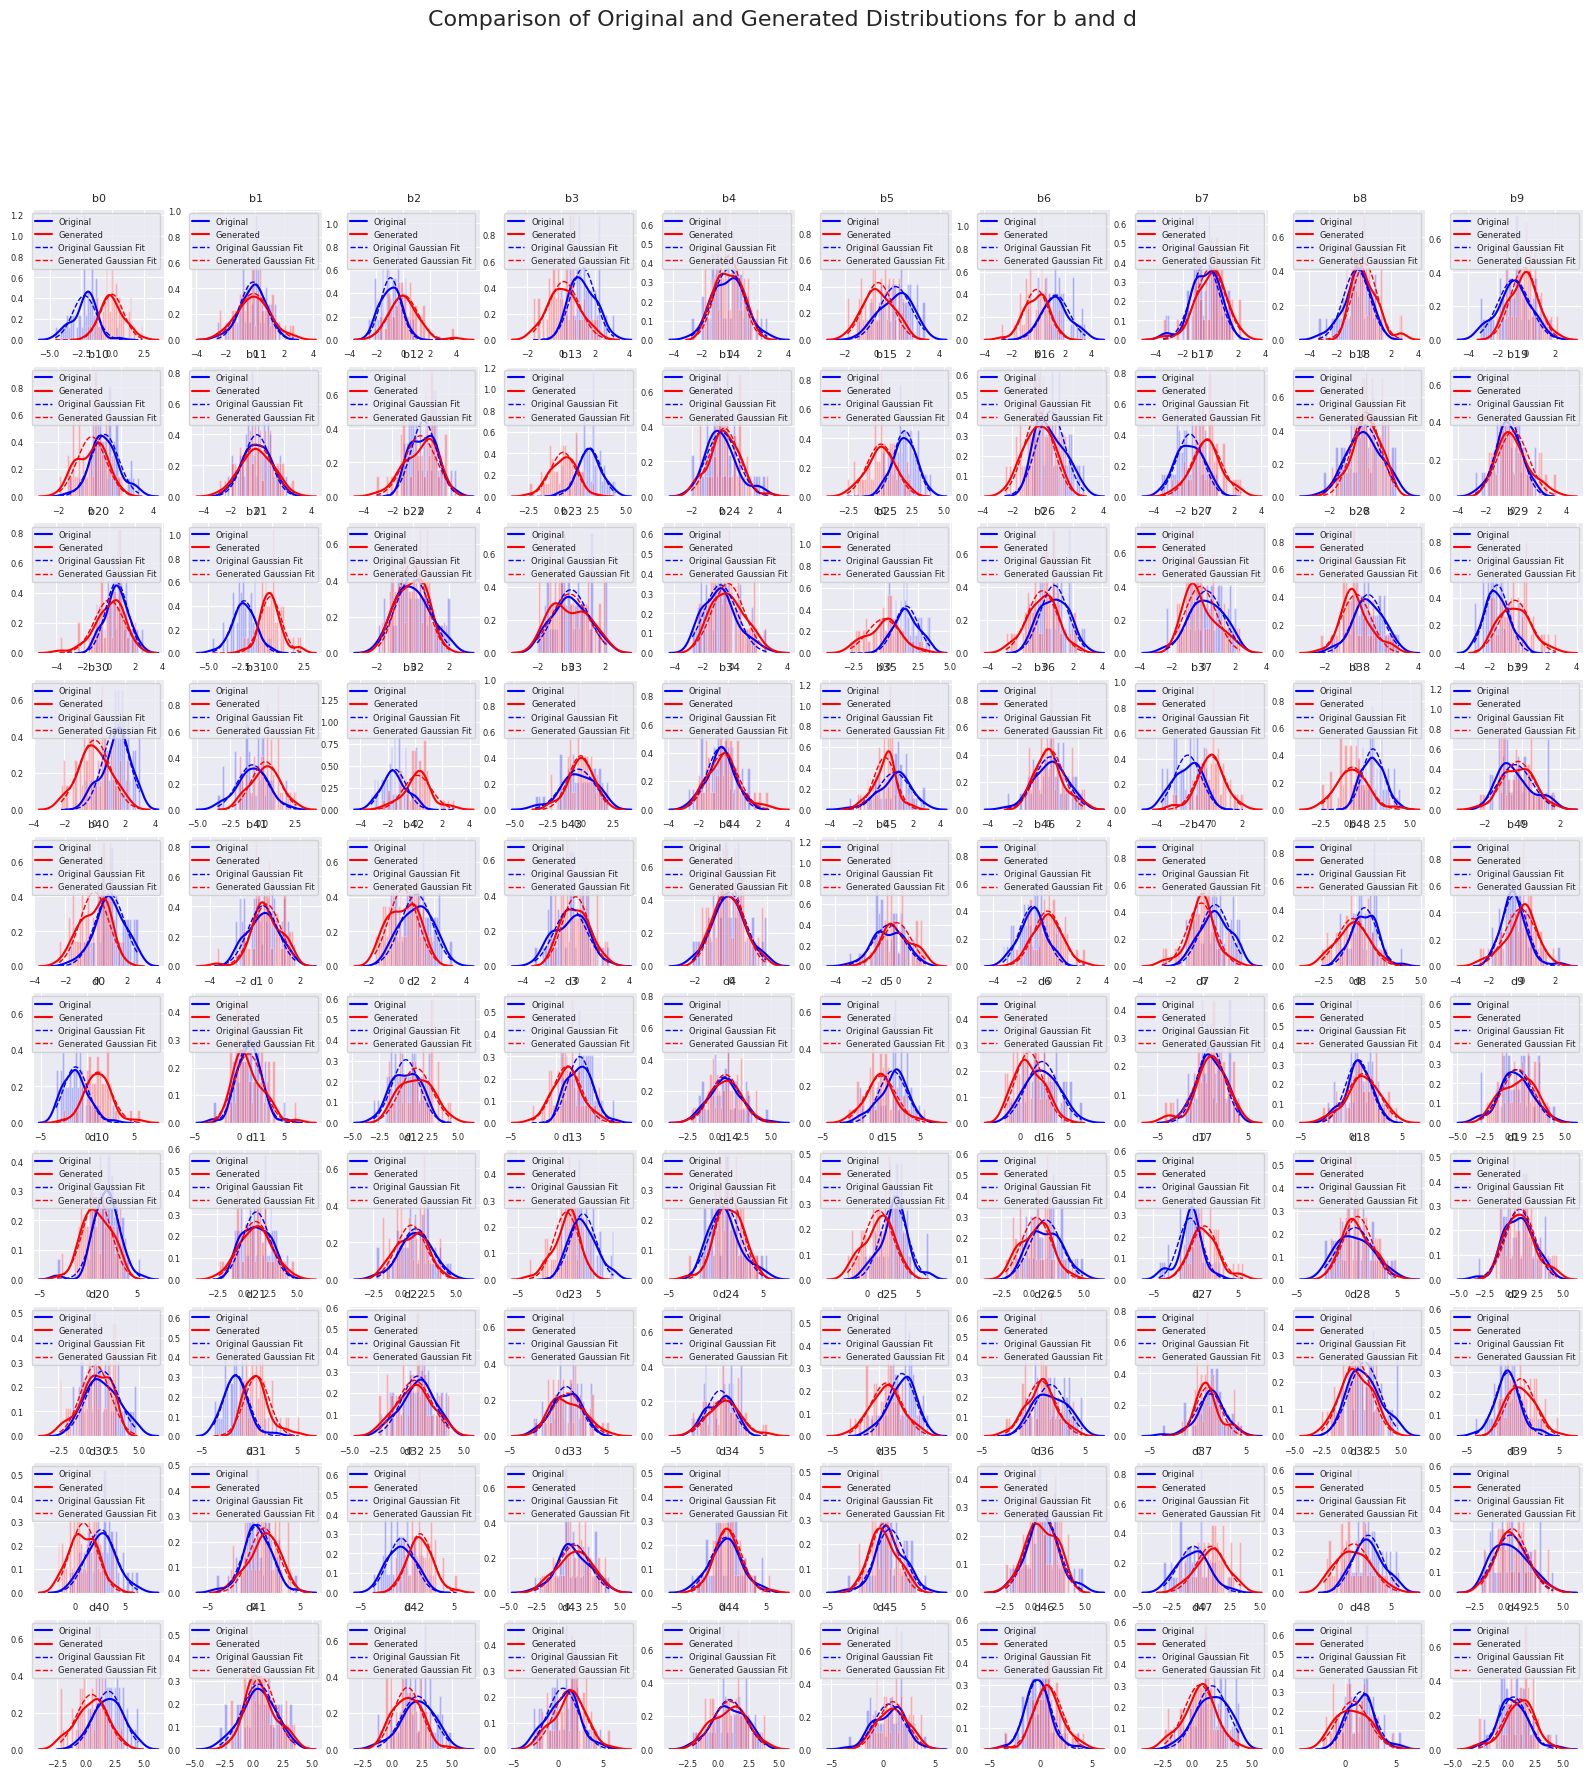

In [14]:
# Variables to plot
variables_bd = ['b', 'd']

# Set up the plot
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
fig.suptitle('Comparison of Original and Generated Distributions for b and d', fontsize=16)

for i, var in enumerate(variables_bd):
    for j in range(50):
        ax = axes[5*i+j//10, j%10]
        
        # Original data
        original = eval(f'{var}')[j]
        
        # Generated data
        generated = generated_data_cond[f'{var}'][j]
        
        # KDE plot
        sns.kdeplot(original, ax=ax, label='Original', color='blue')
        sns.kdeplot(generated, ax=ax, label='Generated', color='red')
        
        # Histogram
        ax.hist(original, bins=30, alpha=0.3, color='blue', density=True)
        ax.hist(generated, bins=30, alpha=0.3, color='red', density=True)
        
        # Fit normal distribution
        mu_orig, std_orig = stats.norm.fit(original)
        mu_gen, std_gen = stats.norm.fit(generated)
        
        x = np.linspace(min(original.min(), generated.min()), 
                        max(original.max(), generated.max()), 100)
        
        ax.plot(x, stats.norm.pdf(x, mu_orig, std_orig), 
                'b--', linewidth=1, label='Original Gaussian Fit')
        ax.plot(x, stats.norm.pdf(x, mu_gen, std_gen), 
                'r--', linewidth=1, label='Generated Gaussian Fit')
        
        ax.set_title(f'{var}{j}', fontsize=8)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='both', labelsize=6)
        ax.legend(fontsize=6)

plt.show()


In [15]:
import json
import os
# Function to save sampled data to a JSON file
def save_sampled_data(data, filename):
    # Delete existing file if it exists
    if os.path.exists(filename):
        os.remove(filename)
    
    # Write new data to file
    print(f"Saving data to {filename}")
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)
    print("Data saved successfully")


In [1]:
def experiment(n):
    all_data = []
    all_kl_divs = []
    for k in range(n):
        data = load_data_from_json(f'data/sampled_intervention_{k}.json')
            
        a = np.array([data[f'a{i}'] for i in range(n_schools)])
        c = np.array([data[f'c{i}'] for i in range(n_schools)])
        e = np.array([data[f'e{i}'] for i in range(n_schools)])
        
        # For b and d, we need to create 2D arrays
        b = np.array([[data[f'_b{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])
        d = np.array([[data[f'_d{i}_{j}'] for j in range(n_students)] for i in range(n_schools)])
        
        with pm.Model() as model:
            # Niveau des écoles
            mu_A = pm.Normal('mu_A', mu=0, sigma=1)
            sigma_A = pm.HalfNormal('sigma_A', sigma=1)
            A_j = pm.Normal('A_j', mu=mu_A, sigma=sigma_A, observed=a)
        
            mu_C = pm.Normal('mu_C', mu=0, sigma=1)
            sigma_C = pm.HalfNormal('sigma_C', sigma=1)
            C_j = pm.Normal('C_j', mu=mu_C, sigma=sigma_C, observed=c)
        
            mu_E = pm.Normal('mu_E', mu=0, sigma=1)
            sigma_E = pm.HalfNormal('sigma_E', sigma=1)
            E_j = pm.Normal('E_j', mu=mu_E, sigma=sigma_E, observed=e)
        
            # B est maintenant une variable observée suivant une loi normale standard
            B_ij = pm.Normal('B_ij', mu=0, sigma=1, observed=b)
        
            # Modèle pour le poids des élèves (D) en fonction des autres variables
            alpha = pm.Normal('alpha', mu=0, sigma=1)
            beta_A = pm.Normal('beta_A', mu=0, sigma=1)
            beta_C = pm.Normal('beta_C', mu=0, sigma=1)
            beta_E = pm.Normal('beta_E', mu=0, sigma=1)
            beta_B = pm.Normal('beta_B', mu=0, sigma=1)
            sigma_D = pm.HalfNormal('sigma_D', sigma=1)
        
            mu_D = alpha + beta_A * A_j[:, None] + beta_C * C_j[:, None] + beta_E * E_j[:, None] + beta_B * B_ij
            D_ij = pm.Normal('D_ij', mu=mu_D, sigma=sigma_D, observed=d)
        
            # Inférence
            trace = pm.sample(50, return_inferencedata=True)
        
        # Résumé des résultats
        print(pm.summary(trace, var_names=['mu_A', 'mu_C', 'mu_E', 'alpha', 'beta_A', 'beta_C', 'beta_E', 'beta_B']), 'experiment', k)
        
        
        generated_data_cond = {}
        
        
        # a
        mu_A_posterior = trace.posterior['mu_A'].mean(dim=('chain', 'draw')).values
        sigma_A_posterior = trace.posterior['sigma_A'].mean(dim=('chain', 'draw')).values
        new_a = np.random.normal(mu_A_posterior, sigma_A_posterior, size=n_schools)
        generated_data_cond['a'] = new_a
        
        # c
        mu_C_posterior = trace.posterior['mu_C'].mean(dim=('chain', 'draw')).values
        sigma_C_posterior = trace.posterior['sigma_C'].mean(dim=('chain', 'draw')).values
        new_c = np.random.normal(mu_C_posterior, sigma_C_posterior, size=n_schools)
        generated_data_cond['c'] = new_c
        
        # e
        mu_E_posterior = trace.posterior['mu_E'].mean(dim=('chain', 'draw')).values
        sigma_E_posterior = trace.posterior['sigma_E'].mean(dim=('chain', 'draw')).values
        new_e = np.random.normal(mu_E_posterior, sigma_E_posterior, size=n_schools)
        generated_data_cond['e'] = new_e
        
        
        # Pour B
        generated_data_cond['b'] = np.random.normal(0, 1, size=(n_schools, n_students))
        
        # Pour D, nous devons recalculer mu_D en utilisant les paramètres estimés
        alpha = trace.posterior['alpha'].mean(dim=('chain', 'draw')).values
        beta_A = trace.posterior['beta_A'].mean(dim=('chain', 'draw')).values
        beta_C = trace.posterior['beta_C'].mean(dim=('chain', 'draw')).values
        beta_E = trace.posterior['beta_E'].mean(dim=('chain', 'draw')).values
        beta_B = trace.posterior['beta_B'].mean(dim=('chain', 'draw')).values
        sigma_D = trace.posterior['sigma_D'].mean(dim=('chain', 'draw')).values
        
        # Calcul de mu_D
        mu_D = (alpha + 
                beta_A * new_a[:, np.newaxis] + 
                beta_C * new_c[:, np.newaxis] + 
                beta_E * new_e[:, np.newaxis] + 
                beta_B * generated_data_cond['b'])
        
        generated_data_cond['d'] = np.random.normal(mu_D, sigma_D)
        
        save_sampled_data(data, f'data/generated_cond_{k}.json')
        
        kl_divs = {}
        
        for var in ['a', 'b', 'c', 'd', 'e']:
            original = eval(var)  # Les données originales
            generated = generated_data_cond[var]  # Les données générées
            
            # Pour b et d, nous devons aplatir les arrays 2D
            if var in ['b', 'd']:
                original = original.flatten()
                generated = generated.flatten() # be careful with is, it's all kl divs ..., not a kl div in 2d or a kl div for each
            
            kl_divs[var] = kl_divergence(original, generated)
        all_data.append((data, generated_data_cond))
    
        all_kl_divs.append(kl_divs)
    
    return all_kl_divs,all_data

            
    

In [ ]:
kl_divs,all_data = experiment(20)

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_0.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 25 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A   -0.285  0.119  -0.496   -0.066      0.006    0.004     460.0     228.0   
mu_C    0.169  0.371  -0.488    0.860      0.018    0.020     392.0     144.0   
mu_E    2.454  0.384   1.614    3.071      0.026    0.020     231.0     157.0   
alpha   1.009  0.064   0.887    1.123      0.006    0.005     100.0     111.0   
beta_A -0.004  0.040  -0.078    0.066      0.003    0.003     147.0     107.0   
beta_C -1.001  0.024  -1.046   -0.960      0.002    0.002     109.0     120.0   
beta_E -0.002  0.018  -0.037    0.032      0.002    0.001     117.0     182.0   
beta_B  0.985  0.018   0.950    1.016      0.001    0.001     410.0     192.0   

        r_hat  
mu_A     1.00  
mu_C     1.02  
mu_E     1.03  
alpha    1.05  
beta_A   1.03  
beta_C   1.04  
beta_E   1.04  
beta_B   1.00   experiment 0
Saving data to data/generated_cond_0.json
Data saved successfully


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_1.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 27 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A   -0.082  0.157  -0.343    0.190      0.007    0.015     460.0     164.0   
mu_C    0.217  0.417  -0.505    1.070      0.027    0.023     253.0     102.0   
mu_E    2.480  0.531   1.513    3.469      0.030    0.021     325.0     160.0   
alpha   1.013  0.060   0.901    1.122      0.006    0.004      92.0     118.0   
beta_A  0.015  0.029  -0.043    0.065      0.002    0.002     229.0     194.0   
beta_C -1.010  0.018  -1.044   -0.981      0.002    0.001      97.0     107.0   
beta_E  0.005  0.016  -0.023    0.033      0.002    0.001     106.0     133.0   
beta_B  0.995  0.021   0.953    1.034      0.001    0.001     232.0     111.0   

        r_hat  
mu_A     1.04  
mu_C     1.01  
mu_E     1.00  
alpha    1.02  
beta_A   1.01  
beta_C   1.01  
beta_E   1.02  
beta_B   1.01   experiment 1
Saving data to data/generated_cond_1.json
Data saved successfully


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_2.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 23 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A    0.053  0.132  -0.188    0.292      0.008    0.009     275.0     150.0   
mu_C    0.994  0.257   0.525    1.461      0.015    0.011     301.0     155.0   
mu_E    1.756  0.328   1.096    2.294      0.020    0.014     279.0     139.0   
alpha   0.892  0.072   0.742    1.013      0.006    0.004     156.0     136.0   
beta_A -0.061  0.032  -0.126   -0.005      0.002    0.002     236.0     156.0   
beta_C -0.964  0.026  -1.010   -0.912      0.002    0.002     148.0     118.0   
beta_E  0.022  0.022  -0.019    0.060      0.002    0.001     166.0     134.0   
beta_B  1.021  0.021   0.980    1.057      0.001    0.001     441.0     127.0   

        r_hat  
mu_A     1.03  
mu_C     1.02  
mu_E     1.01  
alpha    1.02  
beta_A   1.00  
beta_C   1.03  
beta_E   1.04  
beta_B   1.01   experiment 2
Saving data to data/generated_cond_2.json
Data saved successfully


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_3.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 29 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A    0.006  0.135  -0.235    0.260      0.008    0.009     289.0     190.0   
mu_C    0.449  0.450  -0.406    1.170      0.026    0.023     319.0     146.0   
mu_E    2.228  0.447   1.412    2.994      0.025    0.018     314.0     135.0   
alpha   0.966  0.050   0.867    1.056      0.004    0.003     194.0     191.0   
beta_A -0.007  0.031  -0.062    0.047      0.002    0.002     242.0     152.0   
beta_C -0.999  0.017  -1.032   -0.965      0.001    0.001     168.0     164.0   
beta_E  0.004  0.014  -0.024    0.027      0.001    0.001     184.0     186.0   
beta_B  1.018  0.019   0.987    1.052      0.001    0.001     347.0     189.0   

        r_hat  
mu_A     1.02  
mu_C     1.01  
mu_E     1.05  
alpha    1.05  
beta_A   1.01  
beta_C   1.03  
beta_E   1.04  
beta_B   1.03   experiment 3
Saving data to data/generated_cond_3.json
Data saved successfully


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_4.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 25 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A    0.194  0.119  -0.081    0.356      0.006    0.005     400.0     152.0   
mu_C    1.097  0.325   0.485    1.708      0.021    0.016     238.0     137.0   
mu_E    1.814  0.322   1.252    2.402      0.025    0.018     194.0      88.0   
alpha   0.842  0.060   0.750    0.967      0.004    0.003     224.0     161.0   
beta_A -0.015  0.035  -0.073    0.041      0.002    0.002     327.0     172.0   
beta_C -0.958  0.020  -0.993   -0.923      0.001    0.001     190.0     161.0   
beta_E  0.037  0.017   0.002    0.063      0.001    0.001     210.0     117.0   
beta_B  1.023  0.020   0.988    1.062      0.001    0.001     460.0     179.0   

        r_hat  
mu_A     1.01  
mu_C     1.04  
mu_E     1.01  
alpha    1.03  
beta_A   1.02  
beta_C   1.00  
beta_E   1.02  
beta_B   1.04   experiment 4
Saving data to data/generated_cond_4.json
Data saved successfully


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_5.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 24 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A   -0.056  0.174  -0.344    0.289      0.010    0.011     298.0     187.0   
mu_C    0.349  0.483  -0.541    1.100      0.024    0.032     422.0      35.0   
mu_E    2.347  0.561   1.320    3.410      0.030    0.021     357.0     190.0   
alpha   0.956  0.055   0.858    1.065      0.004    0.003     170.0     171.0   
beta_A  0.019  0.036  -0.054    0.078      0.002    0.002     460.0     186.0   
beta_C -0.992  0.017  -1.023   -0.959      0.001    0.001     169.0     153.0   
beta_E  0.013  0.014  -0.013    0.037      0.001    0.001     168.0     160.0   
beta_B  0.992  0.019   0.954    1.024      0.001    0.001     460.0     193.0   

        r_hat  
mu_A     1.03  
mu_C     1.07  
mu_E     1.01  
alpha    1.02  
beta_A   1.05  
beta_C   1.02  
beta_E   1.02  
beta_B   1.01   experiment 5
Saving data to data/generated_cond_5.json
Data saved successfully


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_6.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 25 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A    0.033  0.130  -0.248    0.212      0.007    0.013     327.0     187.0   
mu_C    0.892  0.484   0.022    1.807      0.028    0.020     296.0     160.0   
mu_E    1.889  0.356   1.176    2.571      0.023    0.016     255.0      97.0   
alpha   0.888  0.067   0.778    1.020      0.005    0.004     162.0     146.0   
beta_A  0.067  0.040  -0.001    0.141      0.002    0.002     460.0     150.0   
beta_C -0.979  0.018  -1.010   -0.945      0.001    0.001     189.0     189.0   
beta_E  0.034  0.020  -0.009    0.067      0.002    0.001     152.0     158.0   
beta_B  0.979  0.022   0.943    1.022      0.001    0.001     460.0     146.0   

        r_hat  
mu_A     1.06  
mu_C     1.02  
mu_E     1.02  
alpha    1.00  
beta_A   1.04  
beta_C   1.00  
beta_E   1.00  
beta_B   1.02   experiment 6
Saving data to data/generated_cond_6.json
Data saved successfully


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_7.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, alpha, beta_A, beta_C, beta_E, beta_B, sigma_D]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 26 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A    0.025  0.154  -0.271    0.278      0.010    0.009     250.0     201.0   
mu_C    0.880  0.547  -0.116    1.801      0.027    0.020     397.0     163.0   
mu_E    1.655  0.558   0.886    3.070      0.033    0.026     275.0     190.0   
alpha   0.869  0.054   0.763    0.961      0.005    0.003     125.0     101.0   
beta_A  0.036  0.032  -0.028    0.090      0.002    0.002     194.0     134.0   
beta_C -0.976  0.016  -1.003   -0.942      0.001    0.001     134.0     161.0   
beta_E  0.033  0.016   0.003    0.063      0.002    0.001     105.0     152.0   
beta_B  0.990  0.020   0.957    1.030      0.001    0.001     228.0     190.0   

        r_hat  
mu_A     1.02  
mu_C     1.03  
mu_E     1.06  
alpha    1.02  
beta_A   1.02  
beta_C   1.00  
beta_E   1.03  
beta_B   1.01   experiment 7
Saving data to data/generated_cond_7.json
Data saved successfully


Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


Data successfully loaded from data/sampled_intervention_8.json


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


need to compute also kl divs and data in 2d space for instance with b and d

In [19]:
print(len(all_data))

20


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
variables = list(kl_divs[0].keys())  # Assuming kldivs is a list of dictionaries

# Create subplots for each variable
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    # Extract KL divergence values for the current variable
    kl_values = [kldiv[var] for kldiv in kl_divs]
    
    # Create a KDE plot for the current variable
    sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
    
    # Customize the subplot
    axes[i].set_title(f'KL Divergence Distribution for Variable {var}')
    axes[i].set_xlabel('KL Divergence')
    axes[i].set_ylabel('Density')

# Remove the empty subplot
fig.delaxes(axes[5])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Calculate mean and standard deviation for each variable
for var in variables:
    kl_values = [kldiv[var] for kldiv in kl_divs]
    mean = np.mean(kl_values)
    std = np.std(kl_values)
    print(f"Variable {var}:")
    print(f"  Mean KL Divergence: {mean:.4f}")
    print(f"  Standard Deviation: {std:.4f}")
    print()


In [24]:
with pm.Model() as model:
    # Niveau des écoles
    mu_A = pm.Normal('mu_A', mu=0, sigma=1)
    sigma_A = pm.HalfNormal('sigma_A', sigma=1)
    A_j = pm.Normal('A_j', mu=mu_A, sigma=sigma_A, observed=a)

    mu_C = pm.Normal('mu_C', mu=0, sigma=1)
    sigma_C = pm.HalfNormal('sigma_C', sigma=1)
    C_j = pm.Normal('C_j', mu=mu_C, sigma=sigma_C, observed=c)

    mu_E = pm.Normal('mu_E', mu=0, sigma=1)
    sigma_E = pm.HalfNormal('sigma_E', sigma=1)
    E_j = pm.Normal('E_j', mu=mu_E, sigma=sigma_E, observed=e)

    # Niveau des élèves
    mu_B = pm.Normal('mu_B', mu=0, sigma=1)
    sigma_B = pm.HalfNormal('sigma_B', sigma=1)
    B_ij = pm.Normal('B_ij', mu=mu_B, sigma=sigma_B, observed=b)

    # Modèle pour le poids des élèves (D) en fonction des autres variables
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta_A = pm.Normal('beta_A', mu=0, sigma=1)
    beta_C = pm.Normal('beta_C', mu=0, sigma=1)
    beta_E = pm.Normal('beta_E', mu=0, sigma=1)
    beta_B = pm.Normal('beta_B', mu=0, sigma=1)
    
    beta_D_A3 = pm.Normal('beta_D_A3', mu=1, sigma=1)
    beta_D_A2 = pm.Normal('beta_D_A2', mu=1, sigma=1)

    
    sigma_D = pm.HalfNormal('sigma_D', sigma=1)

    mu_D = alpha + beta_A * A_j[:, None] + beta_C * C_j[:, None] + beta_E * E_j[:, None] + beta_B * B_ij+ beta_D_A3 * A_j[:, None] ** 3 + beta_D_A2 * A_j[:, None] ** 2   
    D_ij = pm.Normal('D_ij', mu=mu_D, sigma=sigma_D, observed=d)

    # Inférence
    trace = pm.sample(50, return_inferencedata=True)

# Résumé des résultats
print(pm.summary(trace, var_names=['mu_A', 'mu_C', 'mu_E', 'mu_B', 'alpha', 'beta_A', 'beta_C', 'beta_E', 'beta_B']))

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, sigma_A, mu_C, sigma_C, mu_E, sigma_E, mu_B, sigma_B, alpha, beta_A, beta_C, beta_E, beta_B, beta_D_A3, beta_D_A2, sigma_D]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Output()

Sampling 4 chains for 1_000 tune and 50 draw iterations (4_000 + 200 draws total) took 24 seconds.
The number of samples is too small to check convergence reliably.


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu_A    0.017  0.134  -0.199    0.289      0.006    0.008     460.0     241.0   
mu_C    1.336  0.490   0.553    2.301      0.028    0.019     314.0     161.0   
mu_E    3.384  0.288   2.910    3.882      0.017    0.012     305.0     195.0   
mu_B    0.035  0.027  -0.014    0.089      0.002    0.001     260.0     187.0   
alpha   1.033  0.057   0.940    1.154      0.005    0.003     148.0     136.0   
beta_A -0.043  0.056  -0.128    0.082      0.004    0.003     179.0     190.0   
beta_C -0.010  0.016  -0.035    0.022      0.001    0.001     134.0     141.0   
beta_E  0.003  0.017  -0.032    0.031      0.001    0.001     144.0     137.0   
beta_B  1.053  0.021   1.010    1.089      0.002    0.001     171.0     111.0   

        r_hat  
mu_A     1.01  
mu_C     1.00  
mu_E     1.01  
mu_B     1.02  
alpha    1.00  
beta_A   1.03  
beta_C   1.05  
beta_E   1.00  
beta_B   1.03  


In [25]:
generated_data = {}

# a
mu_A_posterior = trace.posterior['mu_A'].mean(dim=('chain', 'draw')).values
sigma_A_posterior = trace.posterior['sigma_A'].mean(dim=('chain', 'draw')).values
new_a = np.random.normal(mu_A_posterior, sigma_A_posterior, size=n_schools)
generated_data['a'] = new_a

# c
mu_C_posterior = trace.posterior['mu_C'].mean(dim=('chain', 'draw')).values
sigma_C_posterior = trace.posterior['sigma_C'].mean(dim=('chain', 'draw')).values
new_c = np.random.normal(mu_C_posterior, sigma_C_posterior, size=n_schools)
generated_data['c'] = new_c

# e
mu_E_posterior = trace.posterior['mu_E'].mean(dim=('chain', 'draw')).values
sigma_E_posterior = trace.posterior['sigma_E'].mean(dim=('chain', 'draw')).values
new_e = np.random.normal(mu_E_posterior, sigma_E_posterior, size=n_schools)
generated_data['e'] = new_e


# Pour B
mu_B = trace.posterior['mu_B'].mean(dim=('chain', 'draw')).values
sigma_B = trace.posterior['sigma_B'].mean(dim=('chain', 'draw')).values
generated_data['b'] = np.random.normal(mu_B, sigma_B, size=(n_schools, n_students))

# Pour D, nous devons recalculer mu_D en utilisant les paramètres estimés
alpha = trace.posterior['alpha'].mean(dim=('chain', 'draw')).values
beta_A = trace.posterior['beta_A'].mean(dim=('chain', 'draw')).values
beta_C = trace.posterior['beta_C'].mean(dim=('chain', 'draw')).values
beta_E = trace.posterior['beta_E'].mean(dim=('chain', 'draw')).values
beta_B = trace.posterior['beta_B'].mean(dim=('chain', 'draw')).values
sigma_D = trace.posterior['sigma_D'].mean(dim=('chain', 'draw')).values

# Calcul de mu_D
mu_D = (alpha + 
        beta_A * new_a[:, np.newaxis] + 
        beta_C * new_c[:, np.newaxis] + 
        beta_E * new_e[:, np.newaxis] + 
        beta_B * generated_data['b'])

generated_data['d'] = np.random.normal(mu_D, sigma_D)

# Affichage des formes des données générées
for var in ['a', 'b', 'c', 'd', 'e']:
    print(f"Shape of generated {var}: {generated_data[var].shape}")

print("Generated data:", generated_data)

Shape of generated a: (50,)
Shape of generated b: (50, 50)
Shape of generated c: (50,)
Shape of generated d: (50, 50)
Shape of generated e: (50,)
Generated data: {'a': array([-9.91735120e-01,  8.31057823e-01, -1.08783790e+00,  2.90167325e-02,
        1.03849146e+00,  6.27123178e-01,  6.23998916e-01, -1.10084230e+00,
        4.05811437e-01, -3.66395313e-01,  1.17026369e+00,  8.88469000e-01,
        1.09961295e+00,  8.31561539e-01, -5.63030307e-02, -1.82759870e+00,
        2.19099278e+00, -1.07654105e+00,  9.80085192e-01,  3.19668899e-02,
        1.53218971e+00,  6.66827629e-01,  6.17928367e-01, -6.36715225e-01,
       -1.44247845e+00,  8.55573186e-01,  3.85373503e-01,  1.78260492e+00,
       -1.28396979e+00,  1.67221225e+00, -9.97733761e-01,  1.74779075e-01,
       -9.64090966e-01, -7.20826398e-01,  5.63849651e-01,  2.31189447e-02,
       -2.21237856e+00, -5.94311321e-01,  8.49127533e-01, -4.80462333e-01,
        1.46458573e+00, -8.64156706e-04, -1.23481659e+00,  5.18607291e-01,
       

In [26]:
# Calcul des divergences KL
kl_divs = {}

for var in ['a', 'b', 'c', 'd', 'e']:
    original = eval(var)  # Les données originales
    generated = generated_data[var]  # Les données générées
    
    # Pour b et d, nous devons aplatir les arrays 2D
    if var in ['b', 'd']:
        original = original.flatten()
        generated = generated.flatten()
    
    kl_divs[var] = kl_divergence(original, generated)

# Affichage des résultats
for var, kl_div in kl_divs.items():
    print(f"KL divergence pour {var}: {kl_div}")

KL divergence pour a: 0.01891896815578649
KL divergence pour b: 0.003110690433288112
KL divergence pour c: 0.32144735437470334
KL divergence pour d: 0.0030410784209354614
KL divergence pour e: 0.06033669938370634


/tmp/ipykernel_1555/3110517197.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, ax=ax, color='blue', label='Original', shade=True)
/tmp/ipykernel_1555/3110517197.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(generated, ax=ax, color='red', label='Generated', shade=True)
/tmp/ipykernel_1555/3110517197.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, ax=ax, color='blue', label='Original', shade=True)
/tmp/ipykernel_1555/3110517197.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

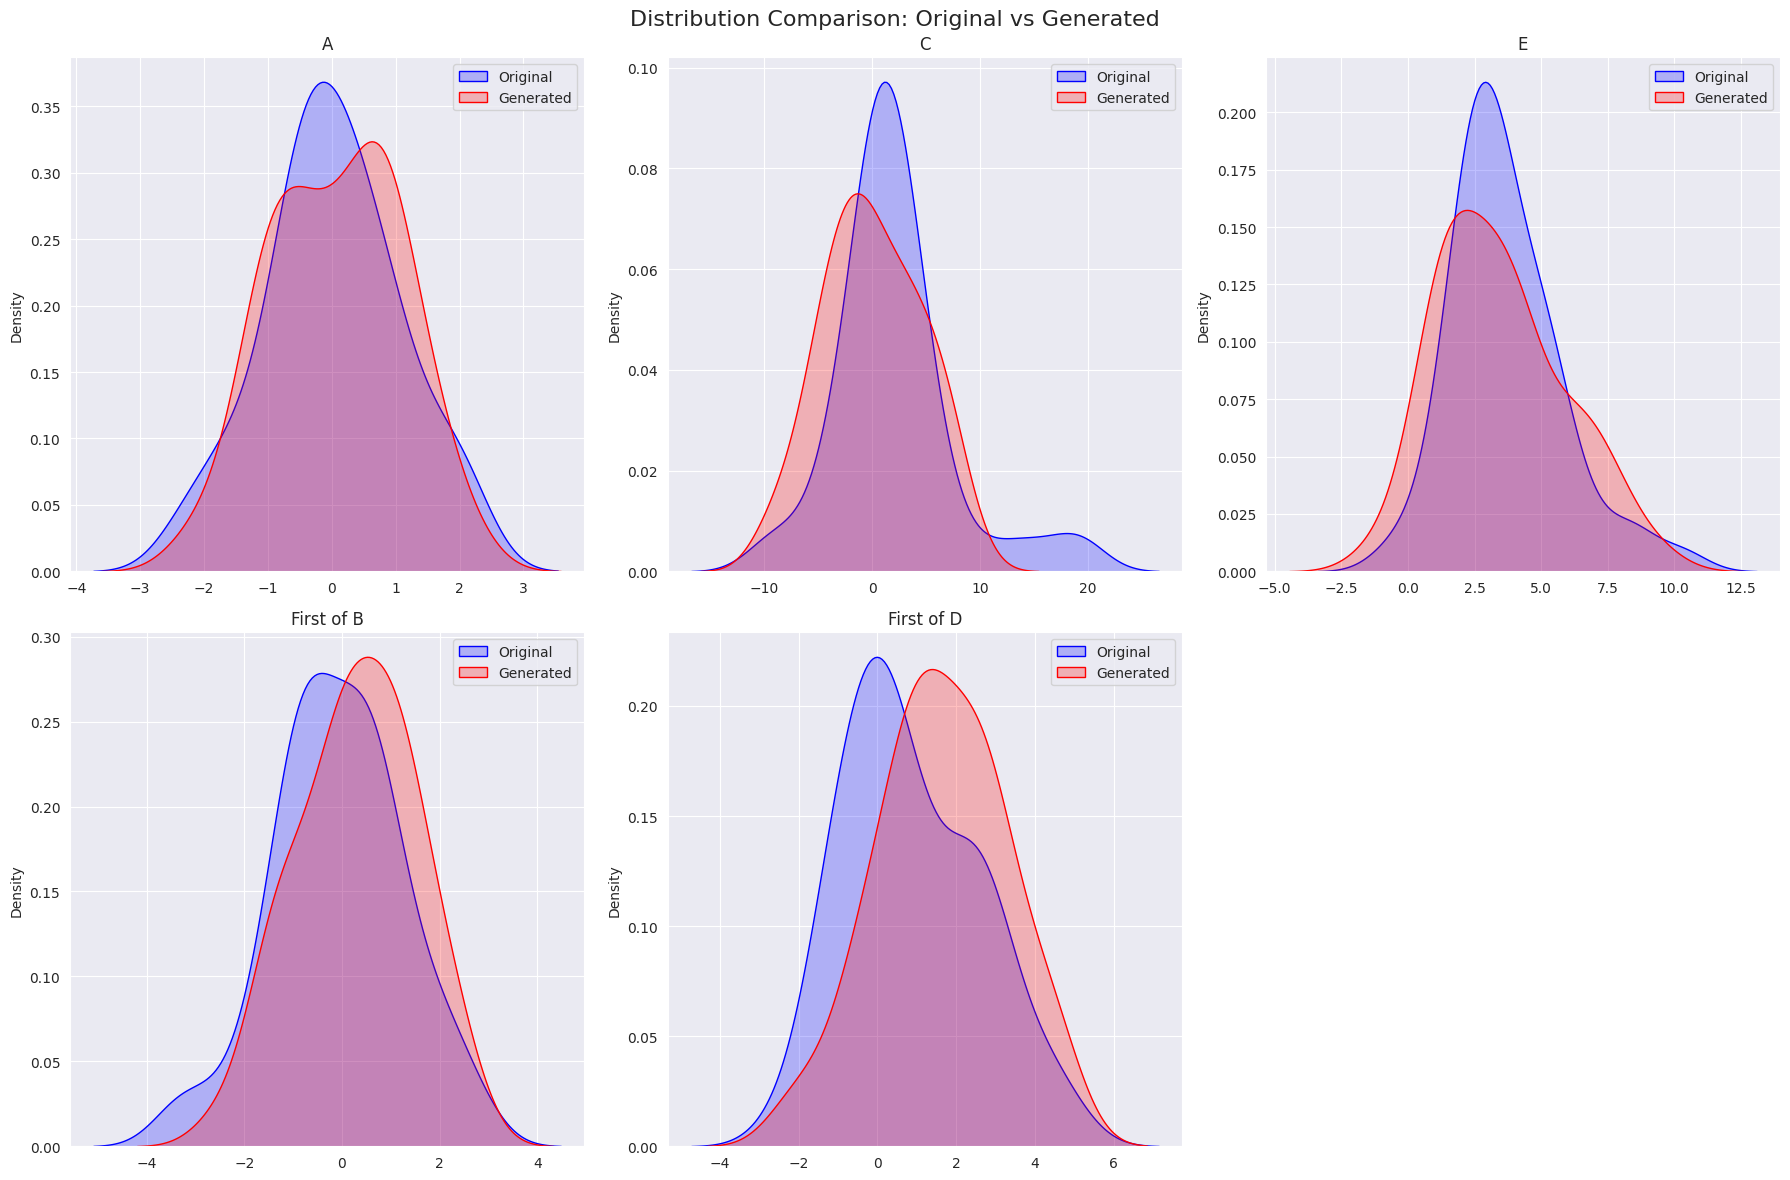

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create subplots for A, C, E, first of B, and first of D
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Distribution Comparison: Original vs Generated', fontsize=16)

variables = ['a', 'c', 'e', 'b', 'd']
titles = ['A', 'C', 'E', 'First of B', 'First of D']

for i, (var, title) in enumerate(zip(variables, titles)):
    ax = axs[i // 3, i % 3]
    
    # Original data
    if var in ['b', 'd']:
        original = eval(var)[:, 0]  # Take first column for B and D
        generated = generated_data[var][:, 0]
    else:
        original = eval(var)
        generated = generated_data[var]
    
    sns.kdeplot(original, ax=ax, color='blue', label='Original', shade=True)
    sns.kdeplot(generated, ax=ax, color='red', label='Generated', shade=True)
    
    ax.set_title(title)
    ax.legend()

# Remove the empty subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()


to see if above is better

Garbage

In [ ]:
import numpy as np


def generate_causal_data(n_schools, n_students):
    data = {}

    # Generate a
    for i in range(n_schools):
        data[f'a{i}'] = np.random.normal(0, 1)

    # Generate b based on a
    for i in range(n_schools):
        for j in range(n_students):
            data[f'_b{i}_{j}'] = (data[f'a{i}'] + 1) ** 2 + np.random.normal(0, 1)

    # Generate c based on a and b
    for i in range(n_schools):
        b_mean = np.mean([data[f'_b{i}_{j}'] for j in range(n_students)])
        data[f'c{i}'] = data[f'a{i}'] + (b_mean + 1) ** 2 + np.random.normal(0, 1)

    # Generate d based on b and c
    for i in range(n_schools):
        for j in range(n_students):
            data[f'_d{i}_{j}'] = (data[f'_b{i}_{j}'] + 1) ** 2 + data[f'c{i}'] + np.random.normal(0, 0.5)

    # Generate e based on c and d
    for i in range(n_schools):
        d_mean = np.mean([data[f'_d{i}_{j}'] for j in range(n_students)])
        data[f'e{i}'] = data[f'c{i}'] + (d_mean + 1) ** 2 + np.random.normal(0, 1)

    return data


# Usage
n_schools = 10
n_students = 50
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
data = generate_causal_data(n_schools, n_students)
n_schools = 50
n_students = 50

unit_vars = ['a', 'c', 'e']
subunit_vars = ['b', 'd']
sizes = [n_students] * n_schools

# Example usage
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
data = {
    **{f'a{i}': i + 1 for i in range(n_schools)},
    **{f'c{i}': i + 5 for i in range(n_schools)},
    **{f'e{i}': i + 11 for i in range(n_schools)}
}

# Generate data for b and d
for i in range(n_schools):
    for j in range(n_students):
        data[f'_b{i}_{j}'] = 2 * i + j % 2 + 1  # This creates a slight variation between students
        data[f'_d{i}_{j}'] = 2 * i + j % 2 + 7  # This creates a slight variation between students



In [1]:
import networkx as nx
import numpy as np
from scipy.stats import norm, gaussian_kde
from scipy.integrate import quad
import pymc as pm


In [2]:
def preprocess_data(self):
        data = {}
        for var in self.unit_vars:
            for i in range(len(self.sizes)):
                data[var+str(i)] = self.data[var+str(i)]
        for var in self.subunit_vars:
            for i in range(len(self.sizes)):
                s = 0
                for j in range(self.sizes[i]):
                    s += self.data['_'+var+str(i)+'_'+str(j)]
                data[var+str(i)] = s / self.sizes[i]
        return data

In [3]:

class HierarchicalBayesSampler:
    def __init__(self, graph, data, unit_vars, subunit_vars, sizes):
        self.graph = nx.DiGraph(graph)
        self.data = data
        self.unit_vars = unit_vars
        self.subunit_vars = subunit_vars
        self.sizes = sizes
        self.processed_data = self.preprocess_data()
        
    def preprocess_data(self):
        data = {}
        for var in self.unit_vars:
            for i in range(len(self.sizes)):
                data[var+str(i)] = self.data[var+str(i)]
        for var in self.subunit_vars:
            for i in range(len(self.sizes)):
                s = 0
                for j in range(self.sizes[i]):
                    s += self.data['_'+var+str(i)+'_'+str(j)]
                data[var+str(i)] = s / self.sizes[i]
        return data

    def generate(self):  # num_samples est maintenant 2
        num_samples = self.sizes[0]
        with pm.Model() as model:
            # Hyperpriors
            mu = {var: pm.Normal(f'mu_{var}', mu=0, sigma=1) for var in self.unit_vars + self.subunit_vars}
            sigma = {var: pm.HalfNormal(f'sigma_{var}', sigma=1) for var in self.unit_vars + self.subunit_vars}

            # Priors pour les variables de niveau supérieur
            variables = {}
            for var in self.unit_vars:
                variables[var] = pm.Normal(var, mu=mu[var], sigma=sigma[var], shape=len(self.sizes))

            # Priors pour les variables de niveau inférieur (sous-unités)
            subunit_variables = {}
            for var in self.subunit_vars:
                for i in range(len(self.sizes)):
                    subunit_variables[f'{var}{i}'] = pm.Normal(f'{var}{i}', mu=mu[var], sigma=sigma[var], shape=self.sizes[i])

            # Likelihood pour les variables de niveau supérieur
            for var in self.unit_vars:
                pm.Normal(f'obs_{var}', mu=variables[var], sigma=1, 
                        observed=np.array([self.processed_data[f'{var}{i}'] for i in range(len(self.sizes))]))

            # Likelihood pour les variables de niveau inférieur (sous-unités)
            for var in self.subunit_vars:
                for i in range(len(self.sizes)):
                    pm.Normal(f'obs_{var}{i}', 
                            mu=subunit_variables[f'{var}{i}'], 
                            sigma=1, 
                            observed=np.array([self.data[f'_{var}{i}_{j}'] for j in range(self.sizes[i])]))

            # Sampling
            trace = pm.sample(num_samples, return_inferencedata=False)

        # Extraction des échantillons
        generated_data = {}
        for var in self.unit_vars:
            generated_data[var] = trace[var][0]  # Prend le premier (et seul) échantillon

        # Extraction et génération des sous-unités
        for var in self.subunit_vars:
            for i in range(len(self.sizes)):
                generated_data[f'{var}{i}'] = trace[f'{var}{i}'][0]  # Prend le premier (et seul) échantillon

        return generated_data
    
    def generate_cond(self):
        num_samples = self.sizes[0]
        with pm.Model() as model:
            # Hyperpriors pour les autres variables
            mu = {var: pm.Normal(f'mu_{var}', mu=0, sigma=1) for var in self.unit_vars + ['d']}
            sigma = {var: pm.HalfNormal(f'sigma_{var}', sigma=1) for var in self.unit_vars + ['d']}

            # Priors pour les variables de niveau supérieur
            variables = {}
            for var in self.unit_vars:
                variables[var] = pm.Normal(var, mu=mu[var], sigma=sigma[var], shape=len(self.sizes))

            # b est défini comme une variable observée suivant une loi normale standard
            b = pm.Normal('b', mu=0, sigma=1, shape=(len(self.sizes), max(self.sizes)), observed=np.random.normal(0, 1, (len(self.sizes), max(self.sizes))))

            # Priors pour les autres variables de niveau inférieur (d)
            subunit_variables = {}
            for i in range(len(self.sizes)):
                subunit_variables[f'd{i}'] = pm.Normal(f'd{i}', mu=mu['d'], sigma=sigma['d'], shape=self.sizes[i])

            # Likelihood pour les variables de niveau supérieur
            for var in self.unit_vars:
                pm.Normal(f'obs_{var}', mu=variables[var], sigma=1, 
                        observed=np.array([self.processed_data[f'{var}{i}'] for i in range(len(self.sizes))]))

            # Likelihood pour d
            for i in range(len(self.sizes)):
                pm.Normal(f'obs_d{i}', 
                        mu=subunit_variables[f'd{i}'], 
                        sigma=1, 
                        observed=np.array([self.data[f'_d{i}_{j}'] for j in range(self.sizes[i])]))

            # Sampling
            trace = pm.sample(num_samples, return_inferencedata=False)

        # Extraction des échantillons
        generated_data = {}
        for var in self.unit_vars:
            generated_data[var] = trace[var][0]

        # Génération de b (toujours à partir d'une loi normale standard)
        for i in range(len(self.sizes)):
            generated_data[f'b{i}'] = np.random.normal(0, 1, size=self.sizes[i])

        # Extraction de d
        for i in range(len(self.sizes)):
            generated_data[f'd{i}'] = trace[f'd{i}'][0]

        return generated_data




In [7]:
import json

def load_data_from_json(file_path):
    """
    Load data from a JSON file and return it as a dictionary.
    
    :param file_path: Path to the JSON file
    :return: Dictionary containing the loaded data
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        print(f"Data successfully loaded from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None



In [8]:
data = load_data_from_json('data/sampled_data.json')

Data successfully loaded from data/sampled_data.json


In [9]:

graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
n_schools = 50
n_students = 50

unit_vars = ['a', 'c', 'e']
subunit_vars = ['b', 'd']
sizes = [n_students] * n_schools

sampling

In [10]:

sampler = HierarchicalBayesSampler(graph, data, unit_vars, subunit_vars, sizes)


In [ ]:
generated_data = sampler.generate()

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_a, mu_c, mu_e, mu_b, mu_d, sigma_a, sigma_c, sigma_e, sigma_b, sigma_d, a, c, e, b0, b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, b14, b15, b16, b17, b18, b19, b20, b21, b22, b23, b24, b25, b26, b27, b28, b29, b30, b31, b32, b33, b34, b35, b36, b37, b38, b39, b40, b41, b42, b43, b44, b45, b46, b47, b48, b49, d0, d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15, d16, d17, d18, d19, d20, d21, d22, d23, d24, d25, d26, d27, d28, d29, d30, d31, d32, d33, d34, d35, d36, d37, d38, d39, d40, d41, d42, d43, d44, d45, d46, d47, d48, d49]


Output()

In [97]:
print( generated_data)


{'a': array([ 1.63065515,  1.7902874 ,  3.64379826,  4.20047022,  5.45190432,
        6.2507369 ,  7.24115763,  8.26437485, 10.2955575 , 10.88087505,
        9.52584466, 12.00288655, 14.51193756, 13.28003449, 14.05469803,
       13.87207749, 16.33657466, 19.49652471, 19.69615   , 19.35336748,
       19.77505565, 22.01298776, 23.0668964 , 24.23471286, 26.58541814,
       27.80412966, 27.22020489, 27.80914964, 29.2355082 , 29.61532339,
       29.50518518, 32.38111287, 32.66135276, 32.95779157, 35.86792962,
       36.30651974, 37.76048832, 39.49839915, 38.49655652, 39.32357128,
       38.85188431, 41.19294883, 41.18251028, 43.25409831, 45.93033013,
       45.32301705, 45.29567944, 47.19897617, 48.98364624, 50.2227248 ]), 'c': array([ 5.18359223,  6.57355743,  7.04102518,  6.76520866,  8.96573395,
        9.88228739, 11.62027158, 11.13115107, 13.83440859, 13.78365585,
       13.96381998, 16.57984348, 16.9390979 , 16.86406085, 20.5648649 ,
       19.55889189, 20.82874816, 20.15223973, 21.07

In [ ]:

generated_data_cond = sampler.generate_cond()

Only 50 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_a, mu_c, mu_e, mu_d, sigma_a, sigma_c, sigma_e, sigma_d, a, c, e, d0, d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15, d16, d17, d18, d19, d20, d21, d22, d23, d24, d25, d26, d27, d28, d29, d30, d31, d32, d33, d34, d35, d36, d37, d38, d39, d40, d41, d42, d43, d44, d45, d46, d47, d48, d49]


Output()

Output()

In [ ]:
print(generated_data_cond)

In [ ]:
from scipy.stats import entropy

def kl_divergence(p, q):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Calculez les histogrammes des deux distributions
    bins = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 1000)
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_hist += epsilon
    q_hist += epsilon
    
    # Normalisez les histogrammes
    p_hist /= np.sum(p_hist)
    q_hist /= np.sum(q_hist)
    
    # Calculez la divergence KL
    return entropy(p_hist, q_hist)


In [ ]:
# Compute KL divergence for 'e' variable
e_generated = generated_data['e']
e_original = np.array([sampler.processed_data[f'e{i}'] for i in range(len(sizes))])

e_generated_cond = generated_data_cond['e']




In [ ]:
kl_div = kl_divergence(e_original, e_generated)
print(f"KL divergence between original 'e' and generated 'e': {kl_div}")
kl_div_cond = kl_divergence(e_original, e_generated_cond)
print(f"KL divergence between original 'e' and generated 'e' with conditionning: {kl_div_cond}")


In [4]:
import numpy as np

In [5]:
import pymc as pm

In [21]:
import numpy as np

def generate_causal_data(n_schools, n_students):
    data = {}
    
    # Generate a
    for i in range(n_schools):
        data[f'a{i}'] =np.random.normal(0, 1)
    
    # Generate b based on a
    for i in range(n_schools):
        for j in range(n_students):
            data[f'_b{i}_{j}'] = (data[f'a{i}']+1)**2 + np.random.normal(0, 1)
    
    # Generate c based on a and b
    for i in range(n_schools):
        b_mean = np.mean([data[f'_b{i}_{j}'] for j in range(n_students)])
        data[f'c{i}'] = data[f'a{i}'] +(b_mean+1)**2 + np.random.normal(0, 1)
    
    # Generate d based on b and c
    for i in range(n_schools):
        for j in range(n_students):
            data[f'_d{i}_{j}'] = (data[f'_b{i}_{j}']+1)**2 +data[f'c{i}'] + np.random.normal(0, 0.5)
    
    # Generate e based on c and d
    for i in range(n_schools):
        d_mean = np.mean([data[f'_d{i}_{j}'] for j in range(n_students)])
        data[f'e{i}'] = data[f'c{i}'] + (d_mean+1)**2 + np.random.normal(0, 1)
    
    return data

# Usage
n_schools = 50
n_students = 50
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
data = generate_causal_data(n_schools, n_students)